# OPEN DATA DAY 2022
---

## Importa as bibliotecas necessárias para a análise

```
pip install pandas
pip install numpy
pip install folium
pip install seaborn
```

In [12]:
import pandas as pd
import numpy as np
import folium 
from folium import plugins
import seaborn as sns

## Le os dados de casos e obítos do estado de São Paulo

In [2]:
df_casos = pd.read_csv(
    '20220220_dados_covid_municipios_sp.csv' , # caminho do arquivo
    encoding= 'iso-8859-1', # encoding, forma que o arquivo foi salvo (caracteres)
    sep = ';' #separados das colunas
)

### Filtra o DataFrame para as cidades da Baixada Santista

In [6]:
# filtra a coluna nome_drs para Baixada Santista e atualiza o df_casos só com as informações da baixada
df_casos = df_casos[ df_casos['nome_drs'] == 'Baixada Santista' ]

## Le o json com os poligonos das cidades do estado de São Paulo

In [7]:
# cria um dataframe em branco com as colunas definidas
df_geo = pd.DataFrame({'CD_MUN': [0], 'NM_MUN': [0], 'SIGLA_UF': [0], 'AREA_KM2': [0], 'geometry': [0]})

# looping para ler todas as linhas do arquivo municipios_sp.json
for idx, info in pd.read_json('municipios_sp.json').iterrows():
    
    # transforma a coluna features em um dicionario
    dict_info = dict(info['features'])
    
    # adiciona as linhas do dicionario no dataframe
    df_geo = df_geo.append({
        'CD_MUN': dict_info['properties']['CD_MUN'],
        'NM_MUN': dict_info['properties']['NM_MUN'],
        'SIGLA_UF': dict_info['properties']['SIGLA_UF'],
        'AREA_KM2': dict_info['properties']['AREA_KM2'],
        'geometry': dict_info['geometry']
        
    } ,ignore_index=True)

### Muda o tipo de dados das colunas

In [8]:
df_geo['CD_MUN'] = df_geo['CD_MUN'].astype(int)
df_casos['codigo_ibge'] = df_casos['codigo_ibge'].astype(int)

### Cria um DataFrame com as informações dos poligonos e a soma de casos e obítos por cidade

In [9]:
# Vamos atualizar o df_geo
df_geo = pd.merge(
    df_geo,
    
    #agrupa o df_casos para somar as colunas casos e obitos
    df_casos.groupby(['codigo_ibge']).agg({'casos_novos': np.sum, 'obitos_novos': np.sum}).reset_index(),
    
    # une os dois dataframes com base nas informacoes do codigo do ibge 
    how = 'inner',
    left_on = 'CD_MUN',
    right_on = 'codigo_ibge'
)

In [39]:
df_geo.head()

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,codigo_ibge,casos_novos,obitos_novos
0,3506359,Bertioga,SP,491.546,"{'type': 'MultiPolygon', 'coordinates': [[[[-4...",3506359,7343,183
1,3513504,Cubatão,SP,142.879,"{'type': 'Polygon', 'coordinates': [[[-46.3328...",3513504,14853,524
2,3518701,Guarujá,SP,144.794,"{'type': 'MultiPolygon', 'coordinates': [[[[-4...",3518701,22651,1390
3,3522109,Itanhaém,SP,601.711,"{'type': 'MultiPolygon', 'coordinates': [[[[-4...",3522109,7200,372
4,3531100,Mongaguá,SP,143.205,"{'type': 'Polygon', 'coordinates': [[[-46.6004...",3531100,2350,96


---

<AxesSubplot:title={'center':'BOX PLOT - CASOS NA BAIXADDA SANTISTA'}, xlabel='casos_novos'>

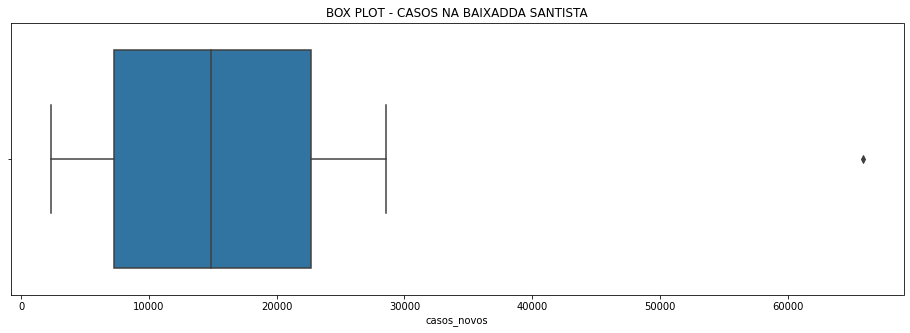

In [38]:
ax = sns.boxplot( data = df_geo, x = 'casos_novos')
ax.figure.set_size_inches(16,5)
ax.set_title('BOX PLOT - CASOS NA BAIXADDA SANTISTA')
ax

## MAPA 01: COLORINDO AS CIDADES DE FORMA MANUAL

In [48]:
def style(feature):
    
    # pega a coluna geometry e transforma para um dicionario
    tt = dict(feature['geometry'])
    
    #busca o nome da cidade no df_geo com base na coluna geometry
    var = df_geo[df_geo['geometry'] == tt].iloc[0]['NM_MUN'] 
    
    # filtro para definir a cor da cidade
    if var == 'Santos':
        color_ = '#03045e'
    elif var in ['Praia Grande', 'Guarujá', 'São Vicente']:
        color_ = '#023e8a'
    elif var == 'Cubatão':
        color_ = '#0077b6'
    elif var in ['Bertioga', 'Peruíbe', 'Itanhaém']:
        color_ = '#0077b6'
    else:
        color_ = '#00b4d8'

    # retorna para o mapa qual sera a cor da cidade
    return {'fillColor': color_,'color': 'white','weight': 1, 'fillOpacity': 0.8} 

# defini uma imagem inicial para o mapa (baixada santista), define um zoom para essa localizacao
# e um estilo de mapa
mapa = folium.Map( location=[-23.947355,-46.3695525], zoom_start=10, tiles='CartoDB positron')

# looping para adicionar cada uma das cidades no mapa
for idx, info in df_geo.iterrows():
    folium.GeoJson(
        info['geometry'], # poligono da cidade
        style_function = style, #chamada da função do estilo de cores
        # nome a ser exibido quando passar o mouse na cidade
        tooltip = "{0}: {1} Casos".format(info['NM_MUN'], info['casos_novos']) 
    ).add_to(mapa)

# exporta o mapa para html
mapa.save('baixada_cor_manual.html')

## MAPA 02: COLORINDO AS CIDADES COM BASE NOS QUARTIS

In [49]:
def style_2(feature):
    tt = dict(feature['geometry'])
    var = df_geo[df_geo['geometry'] == tt].iloc[0]['casos_novos'] 
    
    if var <= df_geo[ 'casos_novos'].quantile(0.25):
        color_ = '#00b4d8'
    elif var > df_geo[ 'casos_novos'].quantile(0.25) and var <= df_geo[ 'casos_novos'].quantile(0.50):
        color_ = '#0077b6'
    elif var >= df_geo[ 'casos_novos'].quantile(0.50) and var <= df_geo[ 'casos_novos'].quantile(0.75):
        color_ = '#023e8a'
    elif var > df_geo[ 'casos_novos'].quantile(0.75):
        color_ = '#03045e'

    return {'fillColor': color_,'color': 'white','weight': 1, 'fillOpacity': 0.8} 


    
mapa = folium.Map( location=[-23.947355,-46.3695525], zoom_start=10, tiles='CartoDB positron')

for idx, info in df_geo.iterrows():
    folium.GeoJson(
        info['geometry'], 
        style_function = style_2,
        tooltip = "{0}: {1} Casos".format(info['NM_MUN'], info['casos_novos'])
    ).add_to(mapa)

mapa.save('baixada_cor_automatica_v1.html')

## MAPA 03: ADICIONANDO MAIS DE UMA MÉTRICA

In [50]:
def style_3(feature):
    tt = dict(feature['geometry'])
    var = df_geo[df_geo['geometry'] == tt].iloc[0][VAR_METRICA] 
    
    if var <= df_geo[VAR_METRICA].quantile(0.25):
        color_ = '#00b4d8'
    elif var > df_geo[VAR_METRICA].quantile(0.25) and var <= df_geo[VAR_METRICA].quantile(0.50):
        color_ = '#0077b6'
    elif var >= df_geo[VAR_METRICA].quantile(0.50) and var <= df_geo[VAR_METRICA].quantile(0.75):
        color_ = '#023e8a'
    elif var > df_geo[VAR_METRICA].quantile(0.75):
        color_ = '#03045e'

    return {'fillColor': color_,'color': 'white','weight': 1, 'fillOpacity': 0.8} 

    
mapa = folium.Map( location=[-23.947355,-46.3695525], zoom_start=5, tiles='CartoDB positron')

VAR_METRICA = 'casos_novos'
casos_ =  folium.FeatureGroup(name = "Casos",).add_to(mapa)
for idx, info in df_geo.iterrows():
    folium.GeoJson(
        info['geometry'], 
        style_function = style_3,
        tooltip = "{0}: {1} Casos".format(info['NM_MUN'], info['casos_novos'])
    ).add_to(casos_)

VAR_METRICA = 'obitos_novos'
casos_ =  folium.FeatureGroup(name = "Obitos", show = False).add_to(mapa)
for idx, info in df_geo.iterrows():
    folium.GeoJson(
        info['geometry'], 
        style_function = style_3,
        tooltip = "{0}: {1} Óbitos".format(info['NM_MUN'], info['obitos_novos'])
    ).add_to(casos_)

    
folium.LayerControl().add_to(mapa)

mapa.save('baixada_cor_automatica_v2.html')

In [ ]:
df_casos['']